<a href="https://colab.research.google.com/github/MathMachado/DSWP/blob/master/Notebooks/NB10_04__3DP_4_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b><i>3DP_4 - ANOMALY/OUTLIER DETECTION</i></b></h1></center>



# **AGENDA**:

> Consulte a **Table of contents**.

# **Melhorias da sessão**
* Mostrar junto os gráficos com a região de Anomaly Score junto com a distribuição de probabilidade das variáveis envolvidas.
* Mensagens de deprecating --> Analisar e substituir os métodos, funções deprecated;


___
# **Referências**
* [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)
* [Outlier detection with several methods](https://scikit-learn.org/0.18/auto_examples/covariance/plot_outlier_detection.html)
* [anomaly-detection-resources](https://github.com/MathMachado/anomaly-detection-resources)
* [Outlier Detection with Extended Isolation Forest](https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b)
* [Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e).

___
## O que é Anomaly Detection (= Análise de Outliers)?
> Qualquer ponto/observação que é incomum quando comparado com todos os outros pontos/observações.

___
# **Machine Learning com Python (Scikit-Learn)**

![Scikit-Learn](https://github.com/MathMachado/Materials/blob/master/scikit-learn-1.png?raw=true)

___
# **Técnicas tradicionais para detecção de outliers**

## Boxplot
* $IQR = Q_{3}-Q_{1}$

![BoxPlot](https://github.com/MathMachado/Materials/blob/master/boxplot.png?raw=true)

## Z-Score
* Z-Score pode ser utilizado para detectar Outliers.
* É a diferença entre o valor e a média da amostra expressa como o número de desvios-padrão. 
* Se o escore z for menor que 2,5 ou maior que 2,5, o valor estará nos 5% do menor ou maior valor (2,5% dos valores em ambas as extremidades da distribuição). No entanto, é pratica comum utilizarmos 3 ao invés dos 2,5.

![Z_Score](https://github.com/MathMachado/Materials/blob/master/Z_Score.png?raw=true)

___
# **Hands-On**

## Carrega as Bibliotecas necessárias

In [ ]:
!pip install pyod

In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest

# Scaling variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF

#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from scipy import stats

# remove warnings to keep notebook clean
import warnings
warnings.filterwarnings('ignore')

## Carrega dataframe

In [ ]:
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

In [ ]:
df_titanic.isna().sum()

In [ ]:
# Por simplicidade, vou descartando/omitindo todos os Missing Values
df_titanic = df_titanic.dropna() # Esta não é a forma adequada! Dê o devido tratamento aos Missing Values (NaN) da base de dados!
df_titanic.head()

In [ ]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = StandardScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [ ]:
# Linhas do df_titanic
df_titanic_ss.shape

In [ ]:
# Função para plotar o Boxplot
def boxplot_sobreviveu(df, column):
    plt.rcdefaults()
    sns.catplot(x = 'survived', y = column, kind = "box", data = df, height = 4, aspect = 1.5)
    
    # add data points to boxplot with stripplot
    sns.stripplot(x = 'survived', y = column, data = df, alpha = 0.3, jitter = 0.2, color = 'k');
    plt.show()

Esta é a visão univariada da variável 'fare':

In [ ]:
df_titanic[['survived']].head()

In [ ]:
boxplot_sobreviveu(df_titanic, 'fare')

In [ ]:
boxplot_sobreviveu(df_titanic_ss, 'fare')

In [ ]:
boxplot_sobreviveu(df_titanic, 'age')

In [ ]:
# Descrever o dataframe, variável 'fare'
pd.set_option('display.float_format', lambda x: '%.3f' %x)
df_titanic_ss['fare'].describe()

## Mostrar a frequência acumulada!! É mais informativo!!!

In [ ]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['fare'].values)) # A intenção do gráfico é ordenar os valores em df_titanic['fare'] do menor valor para o maior!
plt.xlabel('indices')
plt.ylabel('fares')
plt.title("Distribuição da variável fare")

sns.despine()

Com o gráfico acima, podemos ver quais e quantos são os pontos que estão acima de $\mu + 3\sigma$ --> Se usarmos o critério do z-score, todos os pontos acima deste limiar são outliers!

 Colocar os gráficos lado a lado: df_titanic e df_titanic_ss!!

In [ ]:
# Distribuição da variável 'fare' (após StandardScaler)
sns.distplot(df_titanic_ss['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

In [ ]:
# Distribuição da variável 'fare' (após StandardScaler)
sns.distplot(df_titanic['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

### Calcular a mediana e comparar com a média.

In [ ]:
df_titanic.describe()

___
## Kurtosis
> Kurtosis é uma medida estatística que define com que intensidade as caudas de uma distribuição diferem das caudas de uma distribuição Normal. Em outras palavras, a curtose identifica se as caudas de uma determinada distribuição contêm valores extremos.
>> A Kurtosis de uma distribuição Normal padrão é igual a 3. Portanto, se Kurtosis-3 > 0, então isso é o que chamamos de excesso de Kurtosis.
>>> **Alta Kurtosis é um indicador de que os dados possuem caudas pesadas ou outliers**.

* **Dica muito importante**: Normalize os dados antes!

___
## Skewness
> É o grau de distorção da distribuição, ou seja, mede a falta de simetria na distribuição de dados, diferenciando valores extremos em uma cauda versus na outra. Uma distribuição simétrica terá uma assimetria de 0.

![Skewness](https://github.com/MathMachado/Materials/blob/master/Skewness.png?raw=true)

Source: [Skew and Kurtosis: 2 Important Statistics terms you need to know in Data Science](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

### Interpretando a Skewness (Rule of Thumb)
* Se -0.5 < Skewness < 0.5: Dados razoavelmente simétricos;
* Se -1 < Skewness < -0.5: Dados moderadamente negativa;
* Se 0.5 < Skewness < 1: Dados moderadamente positiva;
* Se Skewness < -1: Dados altamente negativa;
* Se Skewness > 1: Dados altamente positiva.

> **Dica**: Normalize os dados antes!

In [ ]:
# Cálculo das medidas de Skewness e Kurtosis para 'fare'
print(f"Skewness: {df_titanic_ss['fare'].skew()}")
print(f"Kurtosis: {df_titanic_ss['fare'].kurt()}")

Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

In [ ]:
# Distribuição da variável 'age'
df_titanic_ss['age'].describe()

In [ ]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['age'].values))
plt.xlabel('index')
plt.ylabel('age')
plt.title("Distribuição da variável age")
sns.despine()

In [ ]:
sns.distplot(df_titanic_ss['age'])
plt.title("Distribuição da variável age")
sns.despine()

In [ ]:
# Cálculo das medidas de Skewness e Kurtosis para 'age'
print(f"Skewness: {df_titanic_ss['age'].skew()}")
print(f"Kurtosis: {df_titanic_ss['age'].kurt()}")

Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

___
## **Isolation Forest Region**
* Source: [Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e)

### Anomaly Detection para 'fare'

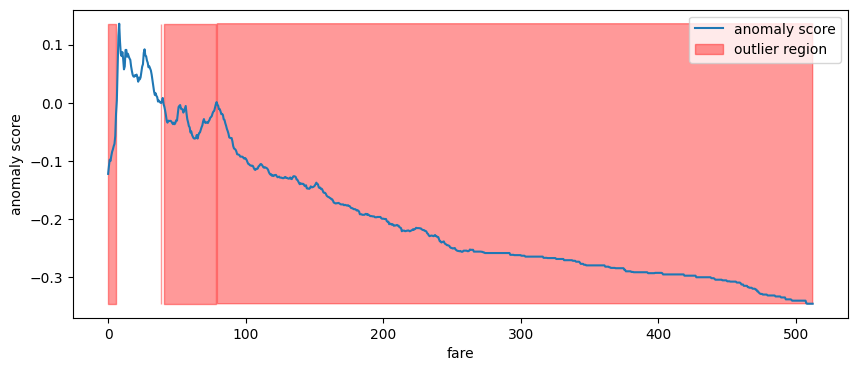

In [41]:
# Instanciamento 
isolation_forest = IsolationForest(n_estimators = 100) 

# Ajustamento (fit())
isolation_forest.fit(df_titanic['fare'].values.reshape(-1, 1))
xx = np.linspace(df_titanic['fare'].min(), df_titanic['fare'].max(), len(df_titanic)).reshape(-1, 1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize = (10, 4))
plt.plot(xx, anomaly_score, label = 'anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where = outlier == -1, color = 'r', alpha = .4, label = 'outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('fare')
plt.show()

**Conclusão**: anomaly_score > 0 --> Não é outliers. Do contrário, ou seja, se anomaly_score < 0 --> Outlier.

In [ ]:
# Vamos avaliar os dados do dataframe para fare > 200, por exemplo
df_titanic.loc[df_titanic['fare'] > 200].head()

In [ ]:
# Zoom na linha 27
df_titanic.loc[27]

A região onde os dados têm baixa probabilidade de aparecer fica no lado direito da distribuição.

### Anomaly Detection para 'age'

In [ ]:
isolation_forest = IsolationForest(n_estimators = 100)
isolation_forest.fit(df_titanic['age'].values.reshape(-1, 1))
xx = np.linspace(df_titanic['age'].min(), df_titanic['age'].max(), len(df_titanic)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize = (10, 4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where = outlier == -1, color = 'r', alpha = .4, label = 'outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('age')
plt.show();

Observe no gráfico acima que há duas regiões em que os dados têm baixa probabilidade de aparecer: uma no lado esquerdo da distribuição, outra no lado direito da distribuição.

In [ ]:
# Avaliando os dados da cauda esquerda
df_titanic.loc[df_titanic['age'] < 15].head()

In [ ]:
# Zoom na linha 3
df_titanic.loc[10]

In [ ]:
# Avaliando dados da cauda direita
df_titanic.loc[df_titanic['age'] > 65].head()

In [ ]:
# Zoom na linha 96
df_titanic.loc[96]

In [ ]:
sns.regplot(x = "age", y = "fare", data = df_titanic_ss)
sns.despine()

In [ ]:
cols = ['fare', 'age']
df_titanic_ss[cols].head()

___
## **CBLOF - Cluster-based Local Outlier Factor**

In [ ]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = MinMaxScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [ ]:
X1 = df_titanic_ss['age'].values.reshape(-1, 1)
X2 = df_titanic_ss['fare'].values.reshape(-1, 1)
X = np.concatenate((X1,X2), axis = 1)

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination = outliers_fraction, check_estimator = False, random_state = 0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize = (8, 8))

df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold para definir um ponto como inlier ou outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly Score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)
        
# Desenha a linha vermelha a partir do qual Anomaly Score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')
        
# Região Azul onde threshold < Anomaly Score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()], colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c = 'white', s = 20, edgecolor = 'k')
    
c = plt.scatter(outliers_fare, outliers_age, c = 'black', s = 20, edgecolor = 'k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop = matplotlib.font_manager.FontProperties(size = 10), loc = 'upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

In [ ]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

In [ ]:
# Zoom na linha 679
df_titanic.loc[679]

In [ ]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

In [ ]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

In [ ]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

___
## **HBOS - Histogram-based Outlier Detection**

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination = outliers_fraction)
clf.fit(X)

# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))

# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1, 1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1, 1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1, 1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1, 1)
         
print('OUTLIERS:', n_outliers, 'INLIERS:', n_inliers)
        
# threshold define se um ponto será outlier ou inlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# Define a região azul tal que min(Anomaly score) < threshold
plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)
        
# Desenha a linha a partir do queal Anomaly score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')
        
# Define a região laranja a partir do qual threshold < Anomaly score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels = [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc ='upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

In [ ]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

In [ ]:
# Zoom na linha 689
df_titanic.loc[689]

In [ ]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

In [ ]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

In [ ]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

___
## **Isolation Forest**

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination = outliers_fraction,random_state = 0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
# fare - inlier feature 1,  age - inlier feature 2
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
# fare - outlier feature 1, age - outlier feature 2
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ', n_outliers,'INLIERS: ', n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [ ]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

In [ ]:
# Zoom na linha 679
df_titanic.loc[679]

In [ ]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

In [ ]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

In [ ]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

___
## **KNN - K-Nearest Neighbors**

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination = outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers, 'INLIERS: ', n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K-Nearest Neighbors (KNN)')
plt.show();

In [ ]:
df1.head()

In [ ]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

In [ ]:
# Zoom na linha 679
df_titanic.loc[679]

In [ ]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

In [ ]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

In [ ]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

___
# **Exercícios**
Para cada um dos dataframes a seguir, faça uma análise de outlier utilizando uma das técnicas apresentadas e explique seus resultados.

## Exercício 1 - Predict Breast Cancer

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer['data']
y = cancer['target']

df_cancer = pd.DataFrame(np.c_[X, y], columns= np.append(cancer['feature_names'], ['target']))
df_cancer['target'] = df_cancer['target'].map({0: 'malign', 1: 'benign'})
df_cancer.head()

## Exercício 2 - Boston Housing Price

In [ ]:
from sklearn.datasets import load_boston

boston = load_boston()
X = boston['data']
y = boston['target']

df_boston = pd.DataFrame(np.c_[X, y], columns = np.append(boston['feature_names'], ['target']))
df_boston.head()

## Exercício 3 - Iris
* [Aqui](https://en.wikipedia.org/wiki/Iris_flower_data_set) você obterá mais informações sobre o dataframe iris.

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X= iris['data']
y= iris['target']

df_iris = pd.DataFrame(np.c_[X, y], columns = np.append(iris['feature_names'], ['target']))
df_iris['target'] = df_iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df_iris.head()

## Exercícios 4 - Diabetes

In [ ]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes['data']
y = diabetes['target']

df_diabetes = pd.DataFrame(np.c_[X, y], columns = np.append(diabetes['feature_names'], ['target']))
df_diabetes.head()